# Lava

Lava is a Python framework for building neural networks that is developed and maintained by Intel. It offers deployment options to Intel's Loihi chips, particularly the newest Loihi 2 chip. 

Lava-dl is an extension of Lava that focuses on deep learning applications and adds more neuron models and also PyTorch-based training algorithms (SLAYER) and model conversions from ANNs. 

NIR has been tested with Lava, and Lava-dl. The following code will show how to import a NIR graph into Lava and Lava-dl. It uses the [NIR2Lava script](https://github.com/neuromorphs/NIR/blob/main/paper/nir_to_lava.py) from the NIR repository.

```{include} ../../../tmp/examples/lava/supported_primitives.md

## Lava <> NIR

In [ ]:
import numpy as np
import nir
import matplotlib.pyplot as plt

ng = nir.NIRGraph(
    nodes=[
        nir.Input(input_type=np.array([3])),
        nir.Affine(weight=np.array([[8, 2, 10], [14, 3, 14]]).T, bias=np.array([1, 2])),
        nir.LIF(
            tau=np.array([1] * 2),
            r=np.array([1] * 2),
            v_leak=np.array([0] * 2),
            v_threshold=np.array([1] * 2),
        ),
        nir.Output(input_type=np.array([3])),
    ],
    edges=[(0, 1), (1, 2), (2, 3)],
)

We can use the `library_preference` argument to specify that we want to convert our NIR graph to Lava (instead of Lava-dl). Additionally, we can also specify a timestep `dt` that is used to discretize the neuron equations, and we can specify if we want the Lava network to run `on_chip` or not (if you don't have access to a Loihi chip, set this to `False` and use Lava's bit-accurate simulator instead), and also whether to use fixed precision (integers) or floating precision. 

In [ ]:
from nir_to_lava import ImportConfig, LavaLibrary, import_from_nir

config = ImportConfig(
    dt=1e-4, fixed_pt=False, on_chip=False, library_preference=LavaLibrary.Lava
)

In [ ]:
lava_nodes, start_nodes, end_nodes = import_from_nir(ng, config)

We now configure the input and output to/from the NIR graph:

In [ ]:
input_data = None  # here you can specify the input data to test your network

In [ ]:
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.proc.io.source import RingBuffer

if config.on_chip:
    from lava.proc.io.sink import RingBuffer as Sink
    from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
    from lava.utils.loihi2_state_probes import StateProbe

ring_buffer = RingBuffer(data=input_data)
first_node = lava_nodes['0']  # point this to the node that should receive the input
last_node = lava_nodes['1'][1]  # point this to the node that should output the result

if config.on_chip:
    sink = Sink(shape=(1,), buffer=input_data.shape[1])
    py2nx = PyToNxAdapter(shape=(1,))
    nx2py = NxToPyAdapter(shape=(1,))

    ring_buffer.s_out.connect(py2nx.inp)
    py2nx.out.connect(first_node.s_in)
    first_node.a_out.connect(last_node.a_in)
    last_node.s_out.connect(nx2py.inp)
    nx2py.out.connect(sink.a_in)
else:
    ring_buffer.s_out.connect(first_node.s_in)

Now we can run the network in Lava (here we assume that the last node is a LIF):

In [ ]:
n_steps = 1000

if config.on_chip:
    probe_v = StateProbe(last_node.v)
    probe_u = StateProbe(last_node.u)
    callbacks = [probe_v, probe_u]
    run_cfg = Loihi2HwCfg(callback_fxs=callbacks)
else:
    mon_volt = Monitor()
    mon_curr = Monitor()
    mon_spk = Monitor()
    mon_inp = Monitor()
    mon_volt.probe(last_node.v, n_steps)
    mon_curr.probe(last_node.u, n_steps)
    mon_spk.probe(last_node.s_out, n_steps)
    mon_inp.probe(ring_buffer.s_out, n_steps)
    tag = "fixed_pt" if config.fixed_pt else "floating_pt"
    run_cfg = Loihi2SimCfg(select_tag=tag)

last_node.run(condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg)
if config.on_chip:
    sink_data = sink.data.get()
    last_node.stop()

And finally we plot the results:

In [ ]:
inp_spikes = input_data.reshape(-1)

if config.on_chip:
    spikes = sink_data.reshape(-1)
    voltage = probe_v.time_series.reshape(-1)
    print(f'spikes: {spikes.shape}, voltage: {voltage.shape}')
else:
    spikes = mon_spk.get_data()['lif']['s_out'].reshape(-1)
    voltage = mon_volt.get_data()['lif']['v'].reshape(-1)
    print(f'spikes: {spikes.shape}, voltage: {voltage.shape}')

sfx = 'fixed' if config.fixed_pt else 'float'
device = 'loihi' if config.on_chip else 'cpu'
with open(f'lif_lava_{device}_{sfx}.csv', 'w') as fw:
    for idx in range(inp_spikes.shape[0]):
        fw.write(f'{inp_spikes[idx]},{voltage[idx]},{spikes[idx]}\n')

fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle(f'LIF ({sfx} pt) on {device}')
# fig.suptitle(f'LIF ({sfx} pt) on {device} with du={du}, dv={dv}, vth={vthr}')
mon_volt.plot(axs[0], last_node.v)
mon_curr.plot(axs[1], last_node.u)
mon_inp.plot(axs[2], ring_buffer.s_out, label='ring buffer output')
axs[2].eventplot(np.argwhere(input_data.reshape(-1) > 0).reshape(-1), color='r', label='data')
axs[2].legend()
# axs[2].set_xticks(np.arange(0, n_steps, 1), minor=True)
axs[0].set_title('LIF voltage')
axs[1].set_title('LIF current')
axs[2].set_title('Input spikes')
plt.tight_layout()
plt.savefig('output.png')
plt.show()

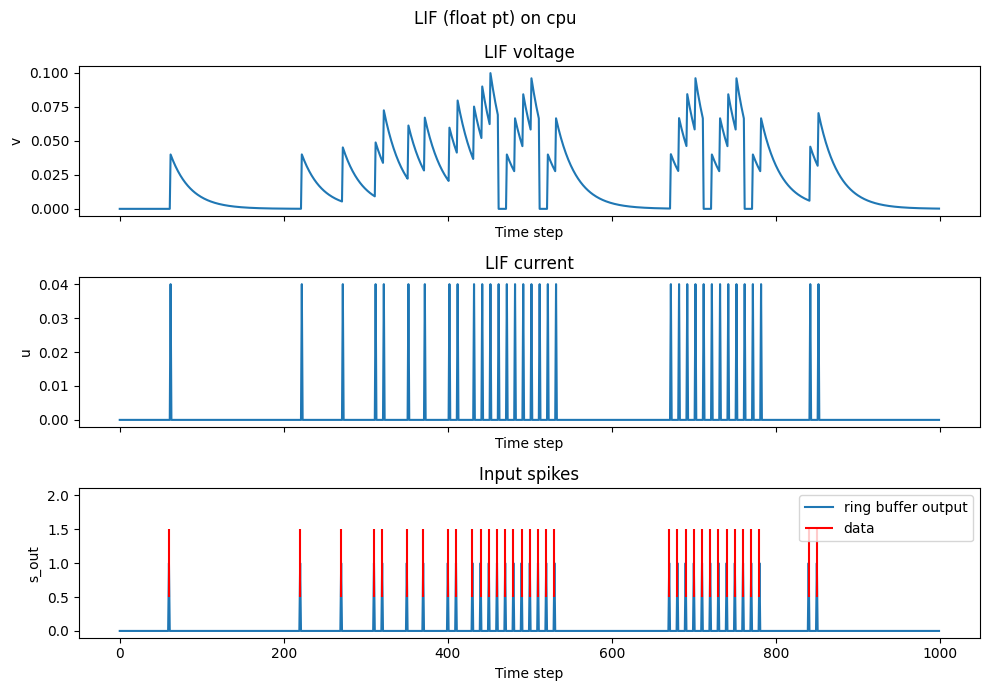

In [1]:
from IPython.display import Image

Image(filename='output.png')

## NIR to Lava-dl

The conversion from NIR to Lava-dl is comparatively simpler, as the resulting object is a PyTorch module that you can run. Here's the code snippet to convert the same NIR graph to a PyTorch network using Lava-dl components. Please see the [lava-dl docs](https://lava-nc.org/dl.html) for more information about lava-dl and how to deply your lava-dl network to a Loihi chip.

In [ ]:
import_config = ImportConfig(library_preference=LavaLibrary.LavaDl)
net = import_from_nir(ng, import_config)